<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#PCA-projection" data-toc-modified-id="PCA-projection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>PCA projection</a></span></li><li><span><a href="#Gaussian-Mixture" data-toc-modified-id="Gaussian-Mixture-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Gaussian Mixture</a></span><ul class="toc-item"><li><span><a href="#Bayesian-Information-Criterion" data-toc-modified-id="Bayesian-Information-Criterion-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Bayesian Information Criterion</a></span></li><li><span><a href="#Save-the-results-of-the-Gaussian-mixtures" data-toc-modified-id="Save-the-results-of-the-Gaussian-mixtures-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Save the results of the Gaussian mixtures</a></span></li></ul></li><li><span><a href="#Plot-results" data-toc-modified-id="Plot-results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot results</a></span></li><li><span><a href="#Plot-Waveforms" data-toc-modified-id="Plot-Waveforms-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot Waveforms</a></span></li></ul></div>

In [65]:
%pylab inline
from matplotlib import style
style.use('https://raw.githubusercontent.com/JoseGuzman/minibrain/master/minibrain/paper.mplstyle')
import pandas as pd
!pwd
!date

Populating the interactive namespace from numpy and matplotlib


/home/segundo.martinez/miniconda3/envs/analysis/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['grid', 'trace']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


/home/segundo.martinez/Dropbox (VBC)/Group Folder Knoblich/Users/Guzman.VCB/MachineLearning
Thu 28 Jan 2021 04:18:41 PM CET


# PCA projection

In [66]:
from minibrain.transformers import PCATransformer

In [67]:
df = pd.read_csv('~/git/minibrain/DataSets/waveforms.csv', index_col='uid')
mydf = df[df['organoid'].isin(['TSCp5_30s', 'TSCp5_32s'])]
mydf.drop('organoid', axis=1, inplace=True)
mydf.shape

/home/segundo.martinez/miniconda3/envs/analysis/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(207, 150)

In [68]:
myPCA = PCATransformer(baseline = 30, n_components = 2)

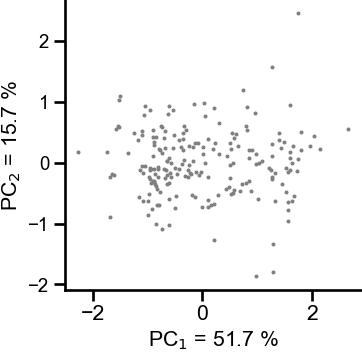

In [69]:
myPC = myPCA.fit_transform(mydf)

fig, ax = plt.subplots(1,1, figsize=(4,4), sharex=True, sharey=True)

ax.scatter(x = myPC.PC1, y = myPC.PC2, s=4, c='gray')
ax.set_xlabel(f'PC$_1$ = {myPCA.pca.explained_variance_ratio_[0]*100:2.1f} %');
ax.set_ylabel(f'PC$_2$ = {myPCA.pca.explained_variance_ratio_[1]*100:2.1f} %');


# Gaussian Mixture

In [70]:
from sklearn.mixture import GaussianMixture

In [71]:
X = myPC[['PC1', 'PC2']].values# Take the first two principal components
X.shape

(207, 2)

## Bayesian Information Criterion

In [72]:
n_components = range(1, 21)
models = [GaussianMixture(n, covariance_type='diag', random_state=42).fit(X)
          for n in n_components]

Number of clusters = 2


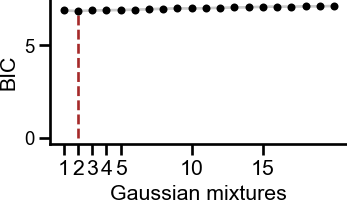

In [73]:
fig, ax = plt.subplots(1,1, figsize = (4,2))

idx = np.arange(1, len(models) + 1)

information = np.log([m.bic(X) for m in models])

myg = information.argmin() +1 # 1-based

ax.plot(idx, information, '-', color='gray', alpha = 0.4)
ax.plot(idx, information, 'ko', ms = 6)

#ax[0].vlines(x = 2, ymin = 0, ymax = inertia[1], lw =2 , linestyle='--', color='C0')


ax.set_xlabel('Gaussian mixtures');
ax.set_xticks([1,2,3,4,5, 10, 15])
#ax.set_ylim(ymin = 7.5)
ax.set_ylabel('BIC');
ax.vlines(x = myg, ymin = 0, ymax = information[myg-1], color='brown', linestyle='--')
print(f'Number of clusters = {myg}')

## Save the results of the Gaussian mixtures

In [74]:

myGmodel = GaussianMixture(n_components = myg, covariance_type='diag', random_state=42).fit(X)
labels = myGmodel.predict(X)

In [75]:
# see indices of left, right and up extreme points in the PC projections
left  = np.argmin(myPC.PC1.values)
right = np.argmax(myPC.PC1.values)
up    = np.argmax(myPC.PC2.values)

print(left, right, up)

# create a numpy where to store the recordings according to the label
gaussian_label = np.empty(labels.size, dtype = np.int)
gaussian_label[np.where(labels==labels[left])]  = 0
gaussian_label[np.where(labels==labels[right])] = 1

156 182 52


In [76]:
gModel = pd.DataFrame(gaussian_label, columns = ['Gaussian'], index = myPC.index)

gModel['color'] = gModel['Gaussian'].map({ 0:'purple', 1: 'green', 2:'orange',})
gModel.head()

,Gaussian,color
uid,,
TC026_029B,0,purple
TC026_041B,0,purple
TC026_044B,0,purple
TC026_045B,0,purple
TC026_080C,0,purple


# Plot results

In [77]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

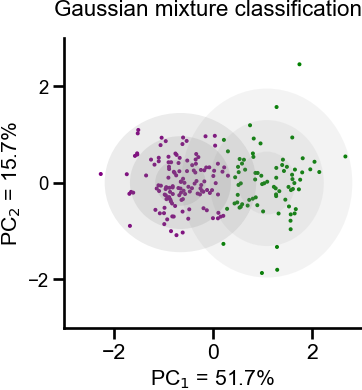

In [78]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
fig.suptitle('Gaussian mixture classification')

ax.scatter(x = myPC.PC1, y = myPC.PC2, s=4, c=gModel.color)
ax.set_xlabel(f'PC$_1$ = {myPCA.pca.explained_variance_ratio_[0]*100:2.1f}%');
ax.set_ylabel(f'PC$_2$ = {myPCA.pca.explained_variance_ratio_[1]*100:2.1f}%');
ax.set_xlim(-3,3), ax.set_ylim(-3,3)
ax.set_yticks([-2,0,2]), ax.set_xticks([-2,0,2]);


w_factor = 0.15 / myGmodel.weights_.max()
for pos, covar, w in zip(myGmodel.means_, myGmodel.covariances_, myGmodel.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor, fc='gray', ax = ax)

# Plot Waveforms

In [82]:
myPC.shape

(207, 152)

In [107]:
trace = myPC.iloc[:,30:-32] # select only traces

/home/segundo.martinez/miniconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice.
/home/segundo.martinez/.local/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


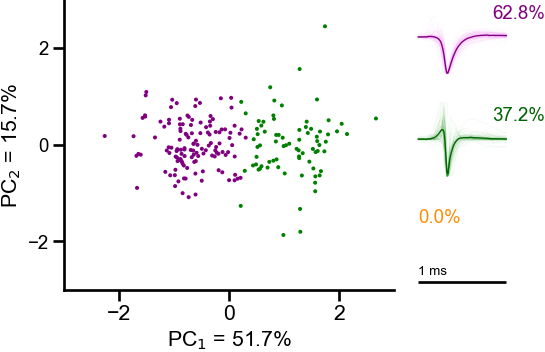

In [115]:
# visualize
# To learn how to use multiple plots, 
# use this https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html

grid = plt.GridSpec(3, 4, wspace=0.2, hspace=0.2)

fig = plt.figure(figsize=(6, 4))
pca_plot = fig.add_subplot(grid[0:3, 0:3])

# Plot PC projections according to Gaussian mixture 

pca_plot.scatter(x = myPC.PC1, y = myPC.PC2, s=4, c=gModel.color)
pca_plot.set_xlabel(f'PC$_1$ = {myPCA.pca.explained_variance_ratio_[0]*100:2.1f}%');
pca_plot.set_ylabel(f'PC$_2$ = {myPCA.pca.explained_variance_ratio_[1]*100:2.1f}%');
pca_plot.set_yticks([-2,0,2]), pca_plot.set_xticks([-2,0,2]);
pca_plot.set_xlim(-3,3), pca_plot.set_ylim(-3,3)

# Group 0 (purple)
fig1 = fig.add_subplot(grid[0, 3])

idx0 = gModel[gModel.Gaussian == 0].index
prop = len(idx0)*100/len(gModel)
wave = trace.loc[idx0].values
for spike in wave:
    fig1.plot(spike, lw=0.5, color='violet', alpha=0.05)
    
fig1.plot(wave.mean(axis=0), lw = 1, color='purple')
fig1.text(x = 75, y = .5, s = f'{prop:2.1f}%', color='purple')

# Group 1 (green)
fig2 = fig.add_subplot(grid[1, 3])

idx1 = gModel[gModel.Gaussian == 1].index
prop = len(idx1)*100/len(gModel)
wave = trace.loc[idx1].values
for spike in wave:
    fig2.plot(spike, lw=0.5, color='green', alpha=0.05)
    
fig2.plot(wave.mean(axis=0), lw = 1, color='darkgreen')
fig2.text(x = 75, y = .5, s = f'{prop:2.1f}%', color='darkgreen')

# Group 2 (orange)
fig3 = fig.add_subplot(grid[2, 3])

idx2 = gModel[gModel.Gaussian == 2].index
prop = len(idx2)*100/len(gModel)
wave = trace.loc[idx2].values
for spike in wave:
    fig3.plot(spike, lw=0.5, color='orange', alpha=0.15)
    
fig3.plot(wave.mean(axis=0), lw = 1, color='darkorange')
fig3.text(x = 75, y = .5, s = f'{prop:2.1f}%', color='darkorange')

fig3.text(x = 75, y= -0.9, s='1 ms', fontsize=10)
fig3.hlines(y = -1.1, xmin =75, xmax = 105, lw=2, color='k') 


for wave in [fig1, fig2, fig3]:
    wave.set_ylim(-1.3,1.0)    
    wave.axis('off')

#fig.savefig('./figures/GaussianMixture.pdf', dpi = 300, tight_layout=True)
#fig.savefig('./figures/GaussianMixture.tiff', dpi = 300, tight_layout=True)
#fig.savefig('../TSC2/Figures/manuscript/ML/GaussianMixture.tiff', dpi = 300, bbox_inches='tight', tight_layout=True)
